<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://docs.unidata.ucar.edu/images/logos/unidata_logo_vertical_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

# Precipitation Accumulation Region of Interest
**Python-AWIPS Tutorial Notebook**

<div style="clear:both"></div>
</div>

---

<div style="float:right; width:250 px"><img src="../images/precip_roi_preview.png" alt="Colorized Precipation Accumulation with Identified Region of Interest" style="height: 300px;"></div>


# Objectives

* Access the model data from an EDEX server and limit the data returned by using model specific parameters
* Calculate the total precipitation over several model runs
* Create a colorized plot for the continental US of the accumulated precipitation data
* Calculate and identify area of highest of precipitation
* Use higher resolution data to draw region of interest

---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Initial-Setup" data-toc-modified-id="Initial-Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Initial Setup</a></span><ul class="toc-item"><li><span><a href="#Geographic-Filter" data-toc-modified-id="Geographic-Filter-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Geographic Filter</a></span></li><li><span><a href="#EDEX-Connection" data-toc-modified-id="EDEX-Connection-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>EDEX Connection</a></span></li><li><span><a href="#Refine-the-Request" data-toc-modified-id="Refine-the-Request-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Refine the Request</a></span></li><li><span><a href="#Get-Times" data-toc-modified-id="Get-Times-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Get Times</a></span></li></ul></li><li><span><a href="#Function:-calculate_accumulated_precip()" data-toc-modified-id="Function:-calculate_accumulated_precip()-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Function: calculate_accumulated_precip()</a></span></li><li><span><a href="#Fuction:-make_map()" data-toc-modified-id="Fuction:-make_map()-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fuction: make_map()</a></span></li><li><span><a href="#Get-the-Data!" data-toc-modified-id="Get-the-Data!-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Get the Data!</a></span></li><li><span><a href="#Plot-the-Data!" data-toc-modified-id="Plot-the-Data!-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Plot the Data!</a></span><ul class="toc-item"><li><span><a href="#Create-CONUS-Image" data-toc-modified-id="Create-CONUS-Image-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Create CONUS Image</a></span></li><li><span><a href="#Create-Region-of-Interest-Image" data-toc-modified-id="Create-Region-of-Interest-Image-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Create Region of Interest Image</a></span></li></ul></li><li><span><a href="#High-Resolution-ROI" data-toc-modified-id="High-Resolution-ROI-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>High Resolution ROI</a></span><ul class="toc-item"><li><span><a href="#New-Data-Request" data-toc-modified-id="New-Data-Request-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>New Data Request</a></span></li><li><span><a href="#Calculate-Data" data-toc-modified-id="Calculate-Data-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Calculate Data</a></span></li><li><span><a href="#Plot-ROI" data-toc-modified-id="Plot-ROI-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Plot ROI</a></span></li></ul></li><li><span><a href="#See-Also" data-toc-modified-id="See-Also-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>See Also</a></span><ul class="toc-item"><li><span><a href="#Related-Notebooks" data-toc-modified-id="Related-Notebooks-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Related Notebooks</a></span></li><li><span><a href="#Additional-Documentation" data-toc-modified-id="Additional-Documentation-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Additional Documentation</a></span></li></ul></li></ul></div>

## Imports

The imports below are used throughout the notebook. Note the first import is coming directly from python-awips and allows us to connect to an EDEX server. The subsequent imports are for data manipulation and visualization.

In [1]:
from awips.dataaccess import DataAccessLayer
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from metpy.units import units
import numpy as np
from shapely.geometry import Point, Polygon

<a href="#top">Top</a>

---

## Initial Setup

### Geographic Filter

By defining a bounding box for the Continental US (CONUS), we’re able to optimize the data request sent to the EDEX server.

In [2]:
conus=[-125, -65, 25, 55]
conus_envelope = Polygon([(conus[0],conus[2]),(conus[0],conus[3]),
                          (conus[1],conus[3]),(conus[1],conus[2]),
                          (conus[0],conus[2])])

### EDEX Connection

First we establish a connection to Unidata’s public EDEX server. With that connection made, we can create a [new data request object](http://unidata.github.io/python-awips/api/IDataRequest.html) and set the data type to **grid**, and use the geographic envelope we just created.

In [3]:
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest("grid", envelope=conus_envelope)

### Refine the Request

Here we specify which model we're interested in by setting the *LocationNames*, and the specific data we're interested in by setting the *Levels* and *Parameters*.

In [4]:
request.setLocationNames("GFS1p0")
request.setLevels("0.0SFC")
request.setParameters("TP")

### Get Times

We need to get the available times and cycles for our model data

In [5]:
cycles = DataAccessLayer.getAvailableTimes(request, True)
times = DataAccessLayer.getAvailableTimes(request)
fcstRun = DataAccessLayer.getForecastRun(cycles[-1], times)

<a href="#top">Top</a>

---

## Function: calculate_accumulated_precip()

Since we'll want to calculate the accumulated precipitation of our data more than once, it makes sense to create a function that we can call instead of duplicating the logic.

This function cycles through all the grid data responses and adds up all of the rainfall to produce a numpy array with the total ammount of rainfall for the given data request.  It also finds the maximum rainfall point in x and y coordinates.

In [6]:
def calculate_accumulated_precip(dataRequest, forecastRun):

    for i, tt in enumerate(forecastRun):
        response = DataAccessLayer.getGridData(dataRequest, [tt])
        grid = response[0]
        if i>0:
            data += grid.getRawData()
        else:
            data = grid.getRawData()
        data[data <= -9999] = 0
        print(data.min(), data.max(), grid.getDataTime().getFcstTime()/3600)

    # Convert from mm to inches
    result = (data * units.mm).to(units.inch)
    
    ii,jj = np.where(result==result.max())
    i=ii[0]
    j=jj[0]

    return result, i, j

<a href="#top">Top</a>

---

## Fuction: make_map()

This function creates the basics of the map we're going to plot our data on. It takes in a bounding box to determine the extent and then adds coastlines for easy frame of reference.

In [7]:
def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(20, 14),
            subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    ax.coastlines(resolution='50m')
    return fig, ax

<a href="#top">Top</a>

---

## Get the Data!

Access the data from the DataAccessLayer interface using the *getGridData* function.  Use that data to calculate the accumulated rainfall, the maximum rainfall point, and the region of interest bounding box.

In [8]:
## get the grid response from edex
response = DataAccessLayer.getGridData(request, [fcstRun[-1]])    
## take the first result to get the location information from
grid = response[0]

## get the location coordinates and create a bounding box for our map
lons, lats = grid.getLatLonCoords()
bbox = [lons.min(), lons.max(), lats.min(), lats.max()]
fcstHr = int(grid.getDataTime().getFcstTime()/3600)

## calculate the total precipitation
tp_inch, i, j = calculate_accumulated_precip(request, fcstRun)
print(tp_inch.min(), tp_inch.max())

## use the max points coordinates to get the max point in lat/lon coords
maxPoint = Point(lons[i][j], lats[i][j])
inc = 3.5
## create a region of interest bounding box
roi_box=[maxPoint.x-inc, maxPoint.x+inc, maxPoint.y-inc, maxPoint.y+inc]
roi_polygon = Polygon([(roi_box[0],roi_box[2]),(roi_box[0],roi_box[3]), 
                (roi_box[1],roi_box[3]),(roi_box[1],roi_box[2]),(roi_box[0],roi_box[2])])

print(maxPoint)

0.0 22.1875 6.0
0.0 43.1875 12.0
0.0 55.8125 18.0
0.0 57.9375 24.0
0.0 96.75 30.0
0.0 111.0625 36.0
0.0 126.375 42.0
0.0 137.75 48.0
0.0 140.25 54.0
0.0 140.4375 60.0
0.0 140.4375 66.0
0.0 140.4375 72.0
0.0 140.5625 78.0
0.0 155.125 84.0
0.0 155.1875 90.0
0.0 155.3125 96.0
0.0 155.375 102.0
0.0 155.375 108.0
0.0 155.375 114.0
0.0 155.375 120.0
0.0 155.375 126.0
0.0 155.375 132.0
0.0 155.375 138.0
0.0 155.375 144.0
0.0 155.8125 150.0
0.0 159.5 156.0
0.0 160.125 162.0
0.0 160.1875 168.0
0.0 160.3125 174.0
0.0 160.375 180.0
0.0 160.4375 186.0
0.0 160.4375 192.0
0.0 160.4375 198.0
0.0 160.4375 204.0
0.0 160.8125 210.0
0.0 160.875 216.0
0.0 160.875 222.0
0.0 160.875 228.0
0.0 160.875 234.0
0.0 160.875 240.0
0.0 inch 6.3336615562438965 inch
POINT (-88 36)


<a href="#top">Top</a>

---

## Plot the Data!

### Create CONUS Image

Plot our data on our CONUS map.

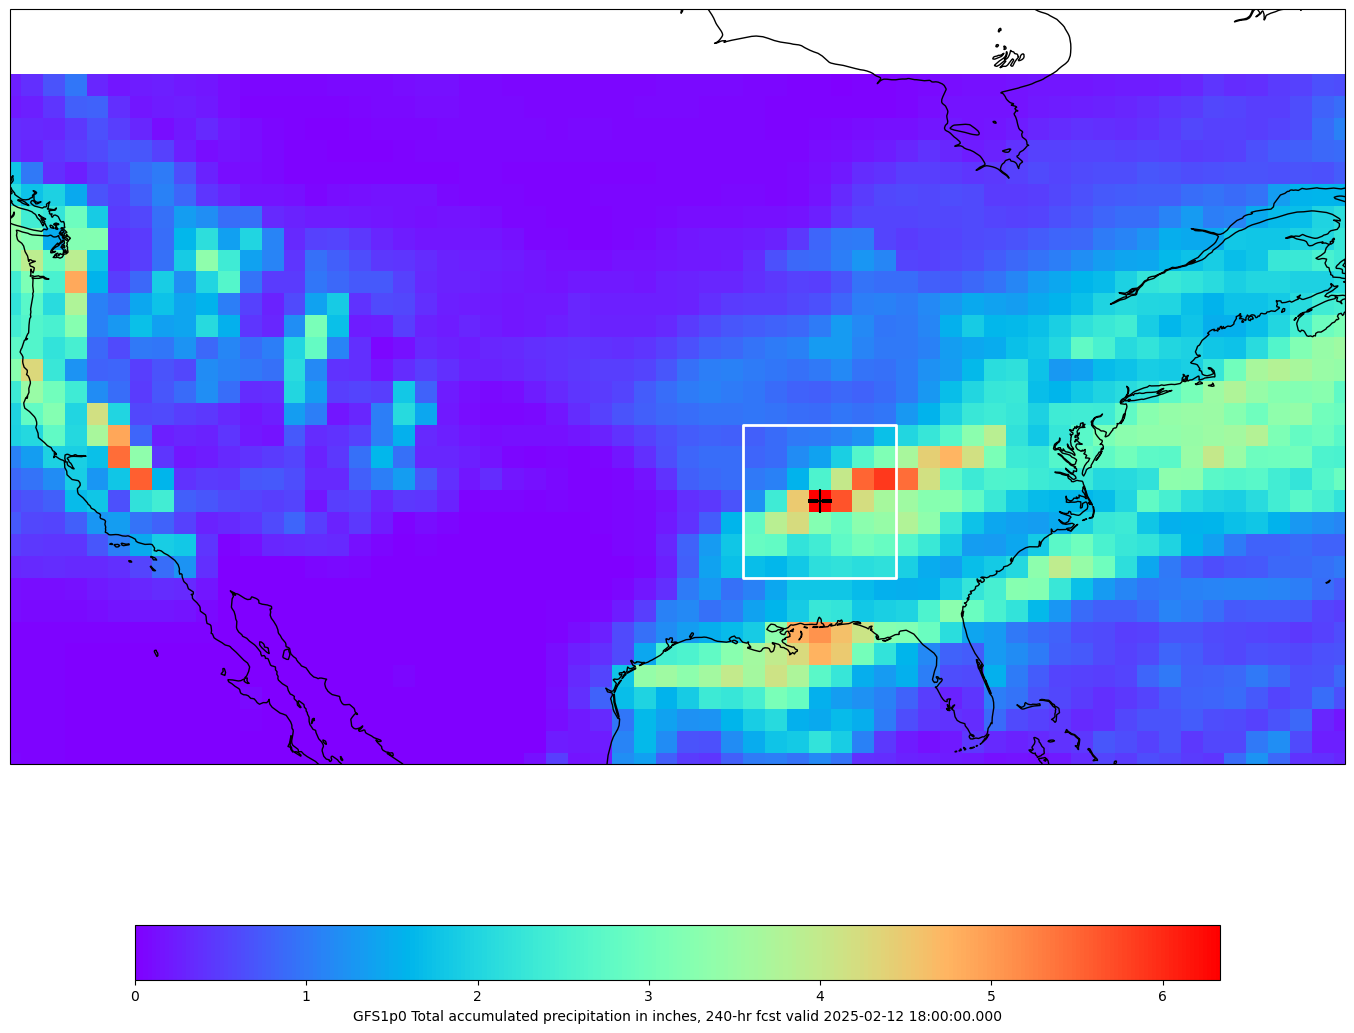

In [9]:
cmap = plt.get_cmap('rainbow')
fig, ax = make_map(bbox=bbox)
cs = ax.pcolormesh(lons, lats, tp_inch, cmap=cmap)
cbar = fig.colorbar(cs, shrink=0.7, orientation='horizontal')
cbar.set_label(grid.getLocationName() + " Total accumulated precipitation in inches, " \
               + str(fcstHr) + "-hr fcst valid " + str(grid.getDataTime().getRefTime()))

ax.scatter(maxPoint.x, maxPoint.y, s=300,
           transform=ccrs.PlateCarree(),marker="+",facecolor='black')

ax.add_geometries([roi_polygon], ccrs.PlateCarree(), facecolor='none', edgecolor='white', linewidth=2)

### Create Region of Interest Image

Now crop the data and zoom in on the region of interest (ROI) to create a new plot.

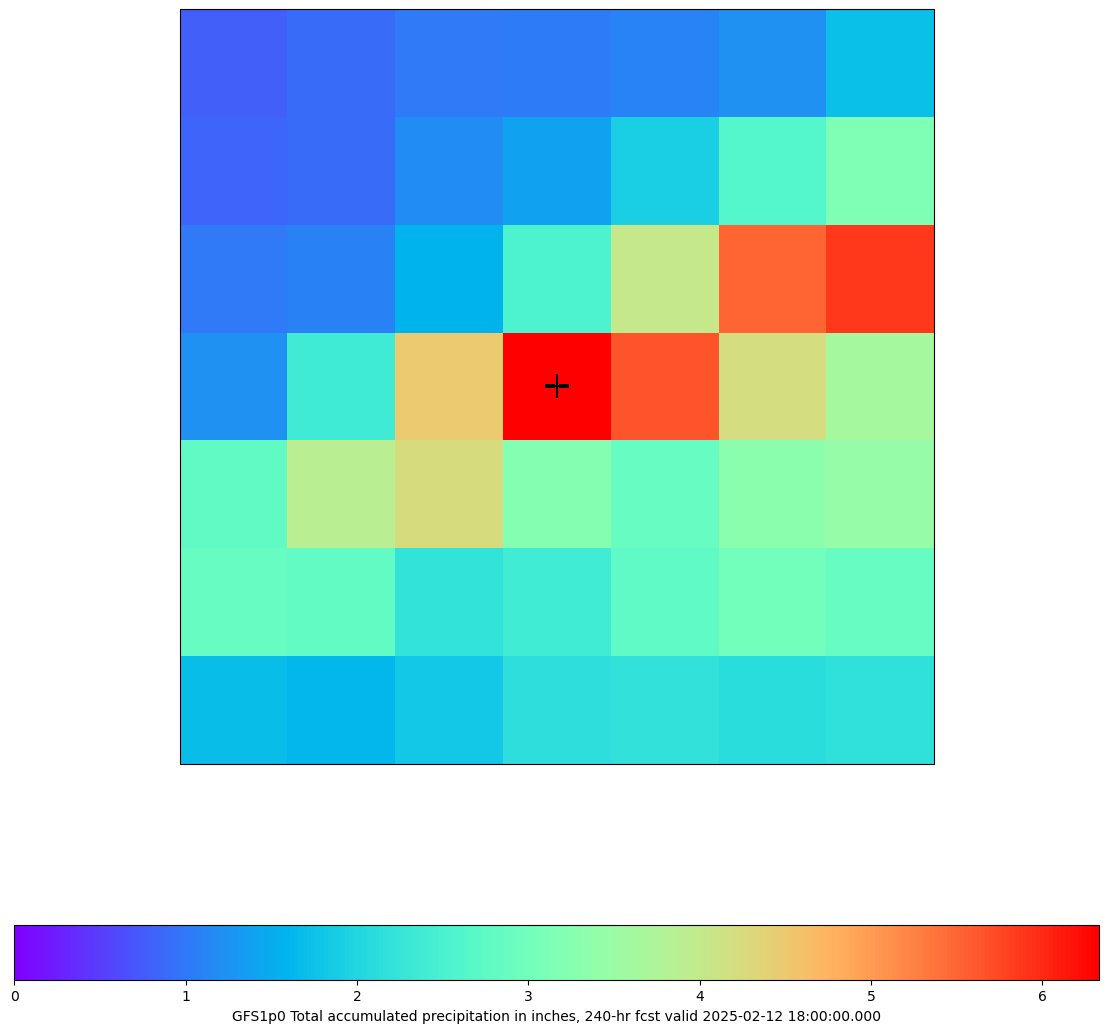

In [10]:
# cmap = plt.get_cmap('rainbow')
fig, ax = make_map(bbox=roi_box)

cs = ax.pcolormesh(lons, lats, tp_inch, cmap=cmap)
cbar = fig.colorbar(cs, shrink=0.7, orientation='horizontal')
cbar.set_label(grid.getLocationName() + " Total accumulated precipitation in inches, " \
               + str(fcstHr) + "-hr fcst valid " + str(grid.getDataTime().getRefTime()))

ax.scatter(maxPoint.x, maxPoint.y, s=300,
           transform=ccrs.PlateCarree(),marker="+",facecolor='black')

<a href="#top">Top</a>

---

## High Resolution ROI

### New Data Request

To see the region of interest more clearly, we can redo the process with a higher resolution model (GFS20 vs. GFS1.0).

In [11]:
roiRequest = DataAccessLayer.newDataRequest("grid", envelope=conus_envelope)
roiRequest.setLocationNames("GFS20")
roiRequest.setLevels("0.0SFC")
roiRequest.setParameters("TP")

roiCycles = DataAccessLayer.getAvailableTimes(roiRequest, True)
roiTimes = DataAccessLayer.getAvailableTimes(roiRequest)
roiFcstRun = DataAccessLayer.getForecastRun(roiCycles[-1], roiTimes)

### Calculate Data

In [12]:
roiResponse = DataAccessLayer.getGridData(roiRequest, [roiFcstRun[-1]])  
print(roiResponse)
roiGrid = roiResponse[0]

roiLons, roiLats = roiGrid.getLatLonCoords()

roi_data, i, j = calculate_accumulated_precip(roiRequest, roiFcstRun)

roiFcstHr = int(roiGrid.getDataTime().getFcstTime()/3600)

0.0 45.4375 3.0
0.0 47.9375 6.0
0.0 48.1875 9.0
0.0 51.75 12.0
0.0 71.1875 15.0
0.0 72.375 18.0
0.0 72.4375 21.0
0.0 81.75 24.0
0.0 107.5 27.0
0.0 131.8125 30.0
0.0 141.6875 33.0
0.0 149.9375 36.0
0.0 159.5 39.0
0.0 171.5625 42.0
0.0 181.9375 45.0
0.0 186.0 48.0
0.0 187.75 51.0
0.0 189.625 54.0
0.0 189.875 57.0
0.0 189.875 60.0
0.0 189.875 63.0
0.0 189.875 66.0
0.0 189.875 69.0
0.0 189.875 72.0
0.0 190.0625 75.0
0.0 190.0625 78.0
0.0 200.375 81.0
0.0 200.8125 84.0
0.0 200.875 90.0
0.0 201.0625 96.0
0.0 201.1875 102.0
0.0 201.25 108.0
0.0 201.25 114.0
0.0 201.25 120.0
0.0 201.25 126.0
0.0 201.25 132.0
0.0 201.25 138.0
0.0 201.25 144.0
0.0 201.375 150.0
0.0 205.9375 156.0
0.0 206.75 162.0
0.0 206.9375 168.0
0.0 207.0625 174.0
0.0 207.1875 180.0
0.0 207.1875 186.0
0.0 207.1875 192.0
0.0 207.1875 198.0
0.0 207.1875 204.0
0.0 207.875 210.0
0.0 208.25 216.0
0.0 208.25 222.0
0.0 208.25 228.0
0.0 208.25 234.0
0.0 208.25 240.0


### Plot ROI

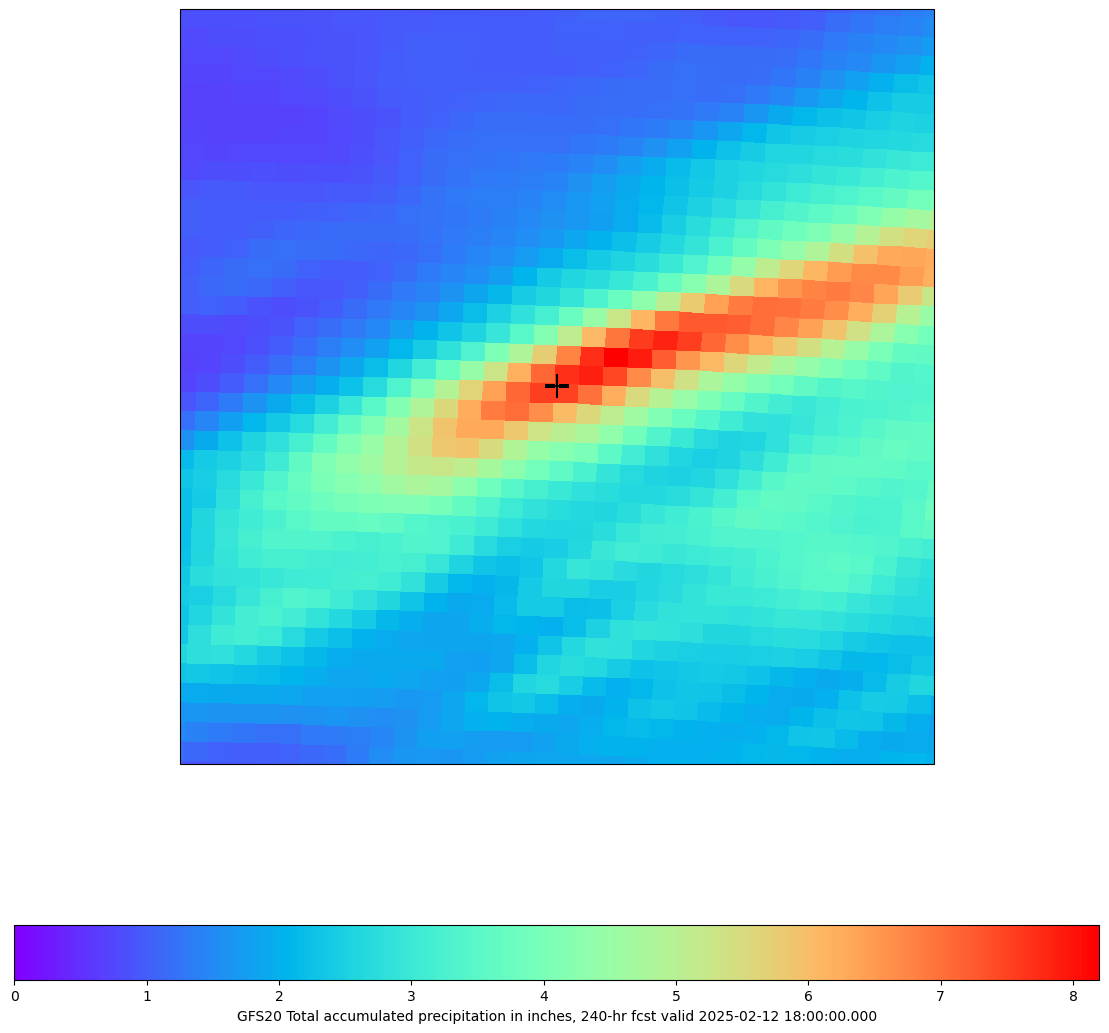

In [13]:
# cmap = plt.get_cmap('rainbow')
fig, ax = make_map(bbox=roi_box)

cs = ax.pcolormesh(roiLons, roiLats, roi_data, cmap=cmap)
cbar = fig.colorbar(cs, shrink=0.7, orientation='horizontal')
cbar.set_label(roiGrid.getLocationName() + " Total accumulated precipitation in inches, " \
               + str(roiFcstHr) + "-hr fcst valid " + str(roiGrid.getDataTime().getRefTime()))

ax.scatter(maxPoint.x, maxPoint.y, s=300,
           transform=ccrs.PlateCarree(),marker="+",facecolor='black')

<a href="#top">Top</a>

---

## See Also

### Related Notebooks

* [Colorized Grid Data](https://unidata.github.io/python-awips/examples/generated/Colorized_Grid_Data.html)
* [Grid Levels and Parameters](https://unidata.github.io/python-awips/examples/generated/Grid_Levels_and_Parameters.html)

### Additional Documentation

**python-awips:**
* [awips.DataAccessLayer](http://unidata.github.io/python-awips/api/DataAccessLayer.html)
* [awips.PyGridData](http://unidata.github.io/python-awips/api/PyGridData.html)

**matplotlib:**
* [matplotlib.pyplot](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.html)
* [matplotlib.pyplot.subplot](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplot.html)
* [matplotlib.pyplot.pcolormesh](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.pcolormesh.html)

<a href="#top">Top</a>

---